# Homework 2

### Due Date: Friday, March 20

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

'1.13.2'

In [2]:
import gym
gym.__version__

'0.16.0'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



***IF you are using MAC, please run below box***

In [3]:
import os
# MAC user only
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [267]:
import tensorflow as tf
import numpy as np
import os
import ipdb




class PolicyOpt(object):

    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]

        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """

#################### Build Your Neural Network Here! ####################

#This neural network architecture is taken from this website: https://prathasaxena30.medium.com/multi-layer-perceptron-with-tensorflow-246b16d4e0dc
# I tried to implement example given in class, model would never converge and remain around -1300.
# While this model does not implement bias nodes as the example does, it represents the architecture presented in class notes: https://drive.google.com/drive/u/1/folders/1SRhppThs_wkOfQ3WK02xixJcSKnQG3_P
# Removing the bias nodes can impact flexibility of the model, but it appears to be running fine with just dense layers.      
        
        num_features = self.obs_dim #Reprsents size of features
        num_hidden = args["hidden_size"]#Number of hidden units
        num_outputs = args["num_actions"] #Number of actions is the expected output dimensions
        s_t = self.s_t_ph #input to NN
        act=args["nonlinearity"] #Specified activation function (relu, tanh, etc.)
        
        l1=tf.layers.dense(s_t, num_hidden , activation=act) #Three dense layers with nonlinear activation function after each layer
        l2= tf.layers.dense(l1, num_hidden , activation=act)
        output_mean = tf.layers.dense(l2, num_outputs)  

##########################################################################        

           
        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None

        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.

        When the policy is stochastic, the action follows 

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ############################################################################ 
            symbolic_action = output_mean + tf.exp(output_logstd)*tf.random.normal(shape=(1,1), mean = 0.0, stddev=1.0,dtype=tf.dtypes.float32)
            
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})

    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError



## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***


In [268]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False) #Session Begins
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[0], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

In [269]:
value_1


array([[0.18702136]], dtype=float32)

Answer: PolicyOpt creates an instantiation of our object and the tensorflow session begins. alg.policy[0] represents the output_mean tensorflow object created using our MLP. Similarly, the input_1 represents the observation which is mapped (in the dictionary definition) to a given state. Therefore, the value 1 represents the mean.

In [270]:
value_2

array([[-0.05820368]], dtype=float32)

Answer: This value represents an action that has been calculated for the given observation labeled as input_1. The compute_action function takes in the "self" object as well as an observation variable (in this case the observation is [0,1,2]). 

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFOCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [272]:
import tensorflow as tf
import tensorflow_probability.python as tfp
import numpy as np
import time


class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=int(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples[:]=[]
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################

        p = tfp.distributions.MultivariateNormalDiag(loc=output_mean, scale_diag=output_logstd)
        log_likelihoods = p.log_prob(self.a_t_ph) #Generates log likelihood of actions

        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]

        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
        v_s = [] #Initialize List
        gamma=self.gamma
        
        for reward in rewards:
            t_prime = len(reward)
            for t in range(t_prime):
                s = sum(reward[t:]) #Finds sum of rewards for each iteration
                diff=t_prime-t
                T = gamma**(diff) #gamma^(t'-t)
                v_s.append(s*T) #adds to v_s list
            
        return v_s
    
    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states,
                                           self.a_t_ph: actions,
                                           self.rew_ph: v_s})

Check your 'log_likelihoods' method by running below cell:

In [273]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})

Test your 'compute_expected_return' by running below cell:

In [274]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])

if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

    

Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [225]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []
for i in range(NUM_TRIALS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Iteration 0 return: -1149.65765903
Iteration 1 return: -1241.96337159
Iteration 2 return: -1289.89453389
Iteration 3 return: -1231.90918614
Iteration 4 return: -1251.10290068
Iteration 5 return: -1255.05330633
Iteration 6 return: -1252.34388913
Iteration 7 return: -1220.86088492
Iteration 8 return: -1263.82985744
Iteration 9 return: -1287.96615796
Iteration 10 return: -1292.31613714
Iteration 11 return: -1329.07077538
Iteration 12 return: -1256.17605748
Iteration 13 return: -1251.37094061
Iteration 14 return: -1245.84235507
Iteration 15 return: -1155.5248605
Iteration 16 return: -1195.92013479
Iteration 17 return: -1158.16998342
Iteration 18 return: -1242.59114871
Iteration 19 return: -1162.98256495
Iteration 20 return: -1158.87191548
Iteration 21 return: -1128.82716777
Iteration 22 return: -1133.97640017
Iteration 23 return: -1121.43494114
Iteration 24 return: -1090.89081145
Iteration 25 return: -1134.14318792
Iteration 26 return: -1110.84776104
Iteration 27 

Iteration 225 return: -249.624774276
Iteration 226 return: -280.920572967
Iteration 227 return: -255.066161045
Iteration 228 return: -287.076986393
Iteration 229 return: -232.212889804
Iteration 230 return: -264.351625423
Iteration 231 return: -241.116111549
Iteration 232 return: -228.83867794
Iteration 233 return: -281.946729841
Iteration 234 return: -222.778190398
Iteration 235 return: -237.339505873
Iteration 236 return: -273.742360036
Iteration 237 return: -248.933772601
Iteration 238 return: -239.380283844
Iteration 239 return: -227.796764406
Iteration 240 return: -204.348068315
Iteration 241 return: -218.336288718
Iteration 242 return: -230.974342543
Iteration 243 return: -237.077246181
Iteration 244 return: -242.966552259
Iteration 245 return: -245.238557453
Iteration 246 return: -241.790303353
Iteration 247 return: -213.691839124
Iteration 248 return: -268.464452246
Iteration 249 return: -191.54535757
Iteration 250 return: -237.388973377
Iteration 251 return: -250.556593307
Ite

Iteration 448 return: -216.828879847
Iteration 449 return: -256.660109099
Iteration 450 return: -224.333353226
Iteration 451 return: -244.930477467
Iteration 452 return: -241.018521368
Iteration 453 return: -225.079563728
Iteration 454 return: -218.646493798
Iteration 455 return: -219.029370431
Iteration 456 return: -240.636320956
Iteration 457 return: -202.760749611
Iteration 458 return: -240.46005414
Iteration 459 return: -192.609105255
Iteration 460 return: -213.9292408
Iteration 461 return: -220.827688701
Iteration 462 return: -235.91065184
Iteration 463 return: -217.243859744
Iteration 464 return: -215.083399377
Iteration 465 return: -204.213455342
Iteration 466 return: -225.694844082
Iteration 467 return: -201.576010124
Iteration 468 return: -201.55476468
Iteration 469 return: -247.816380516
Iteration 470 return: -202.56408463
Iteration 471 return: -187.636801668
Iteration 472 return: -224.077677553
Iteration 473 return: -220.943036666
Iteration 474 return: -240.187204898
Iterati

Iteration 173 return: -335.059443074
Iteration 174 return: -326.668195105
Iteration 175 return: -289.190865998
Iteration 176 return: -254.088669188
Iteration 177 return: -330.516177129
Iteration 178 return: -293.67634208
Iteration 179 return: -313.293877628
Iteration 180 return: -313.137760948
Iteration 181 return: -355.19281991
Iteration 182 return: -336.014084389
Iteration 183 return: -337.208010557
Iteration 184 return: -298.330945723
Iteration 185 return: -330.023864591
Iteration 186 return: -311.110132222
Iteration 187 return: -244.55171876
Iteration 188 return: -329.320795313
Iteration 189 return: -303.713949377
Iteration 190 return: -348.26764242
Iteration 191 return: -320.353567034
Iteration 192 return: -289.798035209
Iteration 193 return: -324.004803409
Iteration 194 return: -255.768252022
Iteration 195 return: -285.603632872
Iteration 196 return: -242.850637307
Iteration 197 return: -311.281607894
Iteration 198 return: -280.91811597
Iteration 199 return: -288.091956619
Iterat

Iteration 396 return: -306.291743637
Iteration 397 return: -236.304364429
Iteration 398 return: -228.473016958
Iteration 399 return: -276.937617601
Iteration 400 return: -267.460921835
Iteration 401 return: -242.081405335
Iteration 402 return: -258.861218526
Iteration 403 return: -271.940885348
Iteration 404 return: -261.984802775
Iteration 405 return: -262.012905099
Iteration 406 return: -253.456355663
Iteration 407 return: -282.397073209
Iteration 408 return: -267.779400553
Iteration 409 return: -257.349286167
Iteration 410 return: -222.250293554
Iteration 411 return: -225.090233559
Iteration 412 return: -251.832911297
Iteration 413 return: -239.487018694
Iteration 414 return: -269.20387335
Iteration 415 return: -249.03636632
Iteration 416 return: -253.134216458
Iteration 417 return: -245.02818177
Iteration 418 return: -296.030718587
Iteration 419 return: -290.605851264
Iteration 420 return: -281.575025001
Iteration 421 return: -237.267464492
Iteration 422 return: -289.489731276
Iter

Iteration 121 return: -968.177064571
Iteration 122 return: -950.614846439
Iteration 123 return: -942.72753327
Iteration 124 return: -931.344427096
Iteration 125 return: -873.334992688
Iteration 126 return: -825.394450293
Iteration 127 return: -869.72684475
Iteration 128 return: -922.076313792
Iteration 129 return: -950.660692131
Iteration 130 return: -987.456695381
Iteration 131 return: -1002.09323641
Iteration 132 return: -888.989460526
Iteration 133 return: -841.267796846
Iteration 134 return: -838.592392099
Iteration 135 return: -905.393618154
Iteration 136 return: -961.025002692
Iteration 137 return: -1006.22606278
Iteration 138 return: -1100.25340065
Iteration 139 return: -1074.0412282
Iteration 140 return: -1129.15706084
Iteration 141 return: -1090.68768829
Iteration 142 return: -1111.6800034
Iteration 143 return: -1075.65884866
Iteration 144 return: -1015.52164101
Iteration 145 return: -959.365635273
Iteration 146 return: -953.551339982
Iteration 147 return: -992.787251165
Itera

Iteration 344 return: -247.784762199
Iteration 345 return: -223.004507453
Iteration 346 return: -252.281398056
Iteration 347 return: -254.887278406
Iteration 348 return: -269.040270728
Iteration 349 return: -233.838199572
Iteration 350 return: -220.138384037
Iteration 351 return: -236.327064591
Iteration 352 return: -231.803130086
Iteration 353 return: -244.872477785
Iteration 354 return: -248.856286832
Iteration 355 return: -234.455486606
Iteration 356 return: -233.025817498
Iteration 357 return: -240.829850254
Iteration 358 return: -239.763689208
Iteration 359 return: -263.689058291
Iteration 360 return: -272.671775813
Iteration 361 return: -248.66708401
Iteration 362 return: -219.879270922
Iteration 363 return: -201.5432362
Iteration 364 return: -274.638169424
Iteration 365 return: -229.314459539
Iteration 366 return: -222.846537653
Iteration 367 return: -210.088609657
Iteration 368 return: -261.70346087
Iteration 369 return: -253.289951208
Iteration 370 return: -216.565618356
Itera

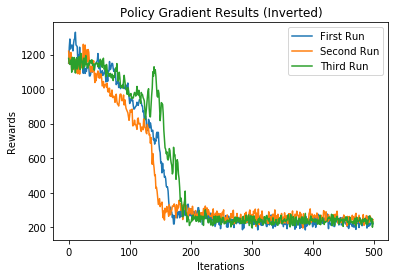

In [276]:
# collect saved results
import numpy as np
import matplotlib.pyplot as pyplot

r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]

##############################################################
# Plot your Policy Gradient results below
##############################################################


pyplot.plot(-r1[0], label="First Run") #Plots first row of CSV
pyplot.plot(-r1[1], label="Second Run") #Plots second row of CSV
pyplot.plot(-r1[2], label="Third Run") #Plots third row of CSV

pyplot.title('Policy Gradient Results (Inverted)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Rewards')

pyplot.legend()

#Graph has been intentionally inverted to more clearly show convergance of gradient!!!
